## 数据预处理

In [3]:
from torchvision.datasets import ImageFolder
import numpy as np
import torch


# 设置随机数生成器种子
seed = 24
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# 数据集根目录
# data_root = './data/sub_img_dataset/coating_shape'  # 子图数据集
data_root = './data/color_dataset/tongue_color' # 颜色数据集
# data_root = './data/dataset_new/tongue_color'
dataset = ImageFolder(root=data_root)

class_names = dataset.classes

print(len(dataset))
print(dataset.class_to_idx)
print(dataset[0])

8000
{'danBai': 0, 'danHong': 1, 'jiangShe': 2, 'qingZi': 3}
(<PIL.Image.Image image mode=RGB size=224x224 at 0x165A26BD390>, 0)


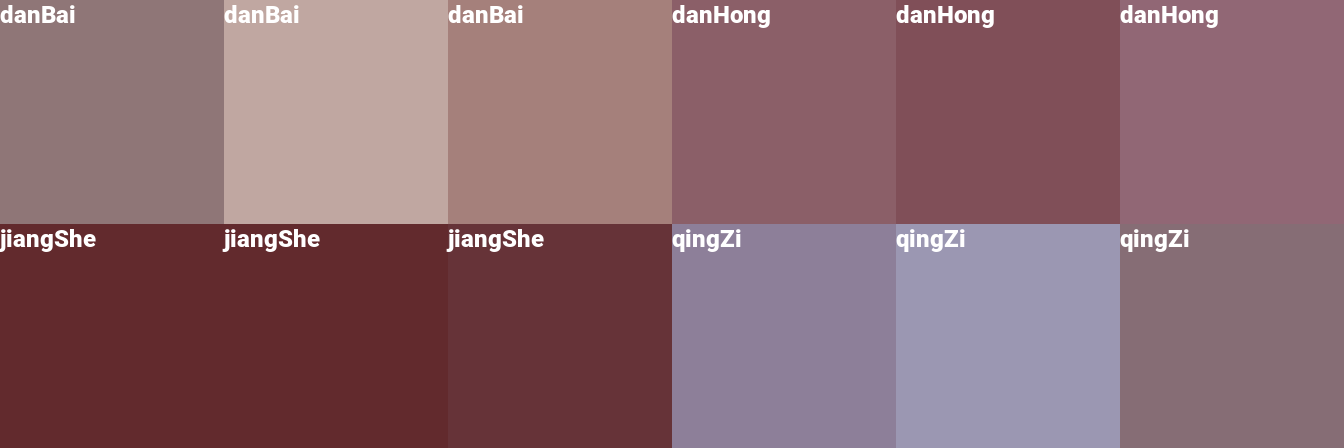

In [4]:
from PIL import Image, ImageDraw, ImageFont
import os
import random


def show_examples(dataset: ImageFolder, examples_per_class=3, size=(224, 224)):
    w, h = size
    labels = dataset.classes
    num_classes = len(labels)

    # 每行至多显示的类别数量
    max_classes_per_row = 2
    # 计算每行显示的示例数量
    examples_per_row = min(
        examples_per_class * max_classes_per_row, num_classes * examples_per_class)
    # 计算显示示例的行数
    num_rows = num_classes * examples_per_class // examples_per_row + (1 if num_classes * examples_per_class % examples_per_row != 0 else 0)
    # 计算网格图像的大小
    grid_size = (examples_per_row * w, num_rows * h)

    grid = Image.new('RGB', size=grid_size, color=(255, 255, 255))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype(
        "C:\\Users\\ChenXi\\fonts\\Roboto\\Roboto-Black.ttf", 24)

    for row in range(num_rows):
        for col in range(max_classes_per_row):
            label_id = row * max_classes_per_row + col
            if label_id >= num_classes:
                break

            label = labels[label_id]

            # 获取该类别的所有图片路径
            class_images = [img_path for img_path,
                            class_label in dataset.imgs if class_label == label_id]

            # 从该类别的所有图片中随机选择 examples_per_class 张图片
            selected_images = random.sample(class_images, min(
                examples_per_class, len(class_images)))

            # 在当前类别的行中绘制图片和标签
            for i, img_path in enumerate(selected_images):
                image = Image.open(img_path)

                # 读取图像的 Exif 信息，获取方向信息
                exif = image._getexif()
                orientation = exif.get(0x0112, 1) if exif else 1

                # 根据方向信息旋转图像
                if orientation == 1:
                    pass
                elif orientation == 3:
                    image = image.rotate(180, expand=True)
                elif orientation == 6:
                    image = image.rotate(270, expand=True)
                elif orientation == 8:
                    image = image.rotate(90, expand=True)

                image = image.resize(size)
                idx = col * examples_per_class + i
                box = (idx * w, row * h)
                grid.paste(image, box=box)
                draw.text(box, label, (255, 255, 255), font=font)  # 在图片上方写标签

    return grid


# 显示数据集示例
show_examples(dataset)

In [3]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader


dataset_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
data_loader.dataset.transform = dataset_transform
# 获取所有图像数据
all_images = None

for inputs, _ in data_loader:
    all_images = inputs

# 计算数据集的均值和标准差
mean = torch.mean(all_images, dim=(0, 2, 3))
std = torch.std(all_images, dim=(0, 2, 3))

print(f"均值：{mean}")
print(f"标准差：{std}")

均值：tensor([0.4791, 0.4038, 0.4168])
标准差：tensor([0.2908, 0.2599, 0.2675])


In [4]:
from torch.utils.data import random_split
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import TensorDataset


class Cutout(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1:y2, x1:x2] = 0

        mask = torch.from_numpy(mask)
        img *= mask.unsqueeze(0)

        return img
    

# 数据增强和预处理
data_augmentation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomApply(transforms.GaussianBlur(3, sigma=(0.1, 2.0)), 0.5),
    Cutout(n_holes=8, length=32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


# # 计算每个类别的样本数量
# class_counts = torch.bincount(torch.tensor(dataset.targets))

# # 计算每个类别的权重
# class_weights = 1 / class_counts.float()


# 划分数据集
train_size = int(4 / 6.0 * len(dataset))
val_size = int(1 / 6.0 * len(dataset))
test_size = len(dataset) - train_size - val_size
remaining_size = len(dataset) - train_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = data_augmentation_transform
val_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform

# 获取训练集的特征和标签
X_train = []
y_train = []
for inputs, labels in train_dataset:
    X_train.append(inputs.numpy())  # 将张量转换为 numpy 数组
    y_train.append(labels)
X_train = np.array(X_train)
y_train = np.array(y_train)

# 创建 RandomOverSampler 实例
ros = RandomOverSampler(random_state=24)

# 进行过采样
X_resampled, y_resampled = ros.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

# 将特征转换回张量形式
X_resampled = torch.tensor(X_resampled.reshape(-1, *inputs.shape))

# 创建过采样后的训练集
oversampled_train_dataset = TensorDataset(X_resampled, torch.tensor(y_resampled))

# 创建 DataLoader
train_loader = DataLoader(oversampled_train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [5]:
# 输出数据集大小
print("过采样后的训练集大小:", len(oversampled_train_dataset))
print("验证集大小:", len(val_dataset))
print("测试集大小:", len(test_dataset))

id2label = {id: label for id, label in enumerate(
    train_dataset.dataset.classes)}
label2id = {label: id for id, label in id2label.items()}

过采样后的训练集大小: 148
验证集大小: 15
测试集大小: 16


In [6]:
from transformers import ViTImageProcessor


# 加载 Vision Transformer 的特征提取器
model_name = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTImageProcessor.from_pretrained(
    model_name,
    do_normalize=False,
    do_resize=False,
    do_rescale=False,
    )
# feature_extractor.image_mean = mean
# feature_extractor.image_std = std
feature_extractor

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": false,
  "do_rescale": false,
  "do_resize": false,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [7]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


def custom_collate(batch):

    # 将样本数据列表拆分为输入和标签
    images, labels = list(zip(*batch))
    inputs = feature_extractor(images, return_tensors='pt')

    inputs['labels'] = torch.tensor(labels)
    inputs['pixel_values'] = torch.stack(
        [input for input in inputs["pixel_values"]])
    return inputs


train_data = MyDataset(train_dataset)
val_data=MyDataset(val_dataset)
test_data=MyDataset(test_dataset)

In [8]:
from transformers import ViTForImageClassification

model_name = "./tongue-disease-classification/tongue_color/checkpoint_on_color"

# model_name 是官方的 transformer 预训练模型

model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(dataset.classes), id2label=id2label,label2id=label2id)

In [9]:
from sklearn.metrics import accuracy_score


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)     
    return dict(accuracy=accuracy_score(predictions, labels))
    # logits, labels = eval_pred
    # predictions = logits.argsort(axis=-1)[:, -5:]  # 获取top-5预测结果
    # # 将标签扩展为与预测结果相同的形状
    # labels_expanded = labels.reshape(-1, 1).repeat(5, axis=1)
    # correct_predictions = (predictions == labels_expanded)  # 判断预测结果是否包含正确标签
    # top5_accuracy = correct_predictions.any(axis=-1).mean()  # 计算top-5准确率
    # return {"accuracy": top5_accuracy}

In [10]:
from transformers import TrainingArguments, Trainer


def train(train_dataset: Dataset,
          valid_dataset: Dataset,
          pre_model_path: str
          ) -> None:
    """[summary]

    Args:
        train_dataset (Dataset): [训练集]
        valid_dataset (Dataset): [验证集]
        pre_model_path (str): [预训练模型文件夹]

    Returns:
        [type]: [description]
    """

    args = TrainingArguments(
        report_to="none",
        output_dir=f"tongue-disease-classification/tongue_color/final_model",
        remove_unused_columns=False,
        save_strategy="epoch",
        evaluation_strategy="epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=30,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_dir='logs',
        warmup_ratio=0.1,
        logging_steps=10,
        seed=seed,
    )

    # 每次训练都要重新载入模型，定义一个函数返回初始化的预训练模型
    def model_init():
        return ViTForImageClassification.from_pretrained(pre_model_path, num_labels=len(dataset.classes), id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

    # 定义一个trainer
    trainer = Trainer(
        # 注意此处不是model
        model_init=model_init,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        data_collator=custom_collate,
        compute_metrics=compute_metrics,
        tokenizer=feature_extractor,
    )

    # 超参数搜索范围
    def hp_space(trial):
        return {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
            "weight_decay": trial.suggest_float("weight_decay", 0.01, 0.3),
            "num_train_epochs": trial.suggest_int("num_train_epochs", 8, 20),
            "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16, 32]),
        }

    # trainer.hyperparameter_search方法进行超参数搜索
    best_trial = trainer.hyperparameter_search(
        direction="maximize",
        backend="optuna",
        n_trials=12,
        hp_space=hp_space,
    )

    print("*************************************")
    print(" Best run %s" % str(best_trial))
    print("*************************************")


train_results = train(train_data, val_data, model_name)

c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
[I 2024-05-09 14:06:51,540] A new study created in memory with name: no-name-23fdb563-1def-46d3-b127-5770adfdf2e5


  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9519152045249939, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3882, 'eval_samples_per_second': 38.64, 'eval_steps_per_second': 5.152, 'epoch': 1.0}
{'loss': 1.2277, 'grad_norm': 5.6095075607299805, 'learning_rate': 1.9445242086348588e-05, 'epoch': 1.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9121362566947937, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.407, 'eval_samples_per_second': 36.855, 'eval_steps_per_second': 4.914, 'epoch': 2.0}
{'loss': 0.8785, 'grad_norm': 7.453813552856445, 'learning_rate': 1.9319788911597954e-05, 'epoch': 2.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9012671113014221, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.409, 'eval_samples_per_second': 36.671, 'eval_steps_per_second': 4.889, 'epoch': 3.0}
{'loss': 0.6263, 'grad_norm': 3.1304399967193604, 'learning_rate': 1.7019814041169624e-05, 'epoch': 3.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8980713486671448, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4007, 'eval_samples_per_second': 37.435, 'eval_steps_per_second': 4.991, 'epoch': 4.0}
{'loss': 0.4603, 'grad_norm': 3.6326675415039062, 'learning_rate': 1.47198391707413e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8944070339202881, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4029, 'eval_samples_per_second': 37.234, 'eval_steps_per_second': 4.965, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.899490237236023, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4052, 'eval_samples_per_second': 37.021, 'eval_steps_per_second': 4.936, 'epoch': 6.0}
{'loss': 0.3037, 'grad_norm': 1.731778860092163, 'learning_rate': 1.2419864300312971e-05, 'epoch': 6.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9166479706764221, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4027, 'eval_samples_per_second': 37.246, 'eval_steps_per_second': 4.966, 'epoch': 7.0}
{'loss': 0.2289, 'grad_norm': 1.6453526020050049, 'learning_rate': 1.0119889429884643e-05, 'epoch': 7.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9199030995368958, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4114, 'eval_samples_per_second': 36.461, 'eval_steps_per_second': 4.862, 'epoch': 8.0}
{'loss': 0.166, 'grad_norm': 1.1726360321044922, 'learning_rate': 7.819914559456315e-06, 'epoch': 8.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.958943247795105, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4016, 'eval_samples_per_second': 37.349, 'eval_steps_per_second': 4.98, 'epoch': 9.0}
{'loss': 0.1089, 'grad_norm': 1.0681359767913818, 'learning_rate': 5.5199396890279866e-06, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9819506406784058, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4035, 'eval_samples_per_second': 37.178, 'eval_steps_per_second': 4.957, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9898821115493774, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4045, 'eval_samples_per_second': 37.084, 'eval_steps_per_second': 4.945, 'epoch': 11.0}
{'loss': 0.0943, 'grad_norm': 0.6053422093391418, 'learning_rate': 3.2199648185996592e-06, 'epoch': 11.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9960560202598572, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4043, 'eval_samples_per_second': 37.103, 'eval_steps_per_second': 4.947, 'epoch': 12.0}
{'loss': 0.111, 'grad_norm': 0.6578208208084106, 'learning_rate': 9.199899481713312e-07, 'epoch': 12.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9950333833694458, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4045, 'eval_samples_per_second': 37.082, 'eval_steps_per_second': 4.944, 'epoch': 13.0}


[I 2024-05-09 14:07:38,004] Trial 0 finished with value: 0.6666666666666666 and parameters: {'learning_rate': 2.138976629498345e-05, 'weight_decay': 0.13479791234707944, 'num_train_epochs': 13, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.6666666666666666.


{'train_runtime': 44.9387, 'train_samples_per_second': 17.646, 'train_steps_per_second': 2.314, 'train_loss': 0.40642483073931474, 'epoch': 13.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9864051342010498, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3993, 'eval_samples_per_second': 37.566, 'eval_steps_per_second': 5.009, 'epoch': 1.0}
{'loss': 1.2493, 'grad_norm': 5.759908199310303, 'learning_rate': 1.0687292507590447e-05, 'epoch': 1.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8784874081611633, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4105, 'eval_samples_per_second': 36.541, 'eval_steps_per_second': 4.872, 'epoch': 2.0}
{'loss': 0.9224, 'grad_norm': 6.611625671386719, 'learning_rate': 8.708164265444068e-06, 'epoch': 2.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8683677911758423, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3923, 'eval_samples_per_second': 38.235, 'eval_steps_per_second': 5.098, 'epoch': 3.0}
{'loss': 0.7592, 'grad_norm': 4.249411582946777, 'learning_rate': 6.729036023297689e-06, 'epoch': 3.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8555719256401062, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4055, 'eval_samples_per_second': 36.99, 'eval_steps_per_second': 4.932, 'epoch': 4.0}
{'loss': 0.6681, 'grad_norm': 4.819243431091309, 'learning_rate': 4.74990778115131e-06, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8509013056755066, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4041, 'eval_samples_per_second': 37.118, 'eval_steps_per_second': 4.949, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8572561144828796, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4055, 'eval_samples_per_second': 36.994, 'eval_steps_per_second': 4.933, 'epoch': 6.0}
{'loss': 0.5506, 'grad_norm': 3.0400338172912598, 'learning_rate': 2.770779539004931e-06, 'epoch': 6.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8561078310012817, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4023, 'eval_samples_per_second': 37.29, 'eval_steps_per_second': 4.972, 'epoch': 7.0}
{'loss': 0.5609, 'grad_norm': 4.508047580718994, 'learning_rate': 7.916512968585517e-07, 'epoch': 7.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8541095852851868, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4041, 'eval_samples_per_second': 37.123, 'eval_steps_per_second': 4.95, 'epoch': 8.0}


[I 2024-05-09 14:08:05,394] Trial 1 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 1.1281030980234362e-05, 'weight_decay': 0.043798059107626616, 'num_train_epochs': 8, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 0.7333333333333333.


{'train_runtime': 26.8359, 'train_samples_per_second': 18.185, 'train_steps_per_second': 2.385, 'train_loss': 0.7646014261990786, 'epoch': 8.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.0801578760147095, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3998, 'eval_samples_per_second': 37.523, 'eval_steps_per_second': 5.003, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8802250623703003, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4064, 'eval_samples_per_second': 36.905, 'eval_steps_per_second': 4.921, 'epoch': 2.0}
{'loss': 1.1413, 'grad_norm': 4.035387992858887, 'learning_rate': 1.1762622112710016e-05, 'epoch': 2.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8915483951568604, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4044, 'eval_samples_per_second': 37.088, 'eval_steps_per_second': 4.945, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9045749306678772, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4039, 'eval_samples_per_second': 37.141, 'eval_steps_per_second': 4.952, 'epoch': 4.0}
{'loss': 0.7943, 'grad_norm': 3.1798036098480225, 'learning_rate': 7.238536684744625e-06, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9019743800163269, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.402, 'eval_samples_per_second': 37.316, 'eval_steps_per_second': 4.975, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8923593163490295, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4062, 'eval_samples_per_second': 36.93, 'eval_steps_per_second': 4.924, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8824558854103088, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4005, 'eval_samples_per_second': 37.452, 'eval_steps_per_second': 4.994, 'epoch': 7.0}
{'loss': 0.6251, 'grad_norm': 2.2906057834625244, 'learning_rate': 2.714451256779234e-06, 'epoch': 7.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8775268197059631, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.405, 'eval_samples_per_second': 37.036, 'eval_steps_per_second': 4.938, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8769839406013489, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4117, 'eval_samples_per_second': 36.433, 'eval_steps_per_second': 4.858, 'epoch': 9.0}


[I 2024-05-09 14:08:35,271] Trial 2 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 1.447707336948925e-05, 'weight_decay': 0.11929901212920138, 'num_train_epochs': 9, 'per_device_train_batch_size': 16}. Best is trial 1 with value: 0.7333333333333333.
c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


{'train_runtime': 29.3303, 'train_samples_per_second': 18.718, 'train_steps_per_second': 1.227, 'train_loss': 0.7988662653499179, 'epoch': 9.0}


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.2341231107711792, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.4034, 'eval_samples_per_second': 37.186, 'eval_steps_per_second': 4.958, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.0148898363113403, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4148, 'eval_samples_per_second': 36.166, 'eval_steps_per_second': 4.822, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8895295858383179, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4038, 'eval_samples_per_second': 37.149, 'eval_steps_per_second': 4.953, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.896277666091919, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4066, 'eval_samples_per_second': 36.887, 'eval_steps_per_second': 4.918, 'epoch': 4.0}
{'loss': 1.1016, 'grad_norm': 3.3170313835144043, 'learning_rate': 1.3466869668776796e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9127358198165894, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.405, 'eval_samples_per_second': 37.035, 'eval_steps_per_second': 4.938, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9202184677124023, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4064, 'eval_samples_per_second': 36.91, 'eval_steps_per_second': 4.921, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9111794829368591, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4064, 'eval_samples_per_second': 36.912, 'eval_steps_per_second': 4.922, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9043075442314148, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4061, 'eval_samples_per_second': 36.934, 'eval_steps_per_second': 4.925, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8983993530273438, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4049, 'eval_samples_per_second': 37.046, 'eval_steps_per_second': 4.94, 'epoch': 9.0}
{'loss': 0.658, 'grad_norm': 1.8630684614181519, 'learning_rate': 7.345565273878252e-06, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8945851922035217, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4011, 'eval_samples_per_second': 37.401, 'eval_steps_per_second': 4.987, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8935194611549377, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3985, 'eval_samples_per_second': 37.638, 'eval_steps_per_second': 5.018, 'epoch': 11.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8925644159317017, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4048, 'eval_samples_per_second': 37.059, 'eval_steps_per_second': 4.941, 'epoch': 12.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8932279944419861, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.403, 'eval_samples_per_second': 37.218, 'eval_steps_per_second': 4.962, 'epoch': 13.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8945623636245728, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4029, 'eval_samples_per_second': 37.231, 'eval_steps_per_second': 4.964, 'epoch': 14.0}
{'loss': 0.4637, 'grad_norm': 1.5727838277816772, 'learning_rate': 1.2242608789797086e-06, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8959006071090698, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4079, 'eval_samples_per_second': 36.774, 'eval_steps_per_second': 4.903, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.896540641784668, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4076, 'eval_samples_per_second': 36.804, 'eval_steps_per_second': 4.907, 'epoch': 16.0}


[I 2024-05-09 14:09:29,643] Trial 3 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 1.7139652305715922e-05, 'weight_decay': 0.06162241753579579, 'num_train_epochs': 16, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.7333333333333333.


{'train_runtime': 53.8044, 'train_samples_per_second': 18.14, 'train_steps_per_second': 0.595, 'train_loss': 0.7206102982163429, 'epoch': 16.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/208 [00:00<?, ?it/s]

{'loss': 1.374, 'grad_norm': 9.813141822814941, 'learning_rate': 1.3979026892399004e-05, 'epoch': 0.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8918516635894775, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4037, 'eval_samples_per_second': 37.153, 'eval_steps_per_second': 4.954, 'epoch': 1.0}
{'loss': 0.9813, 'grad_norm': 6.424622535705566, 'learning_rate': 2.795805378479801e-05, 'epoch': 1.25}
{'loss': 0.9002, 'grad_norm': 8.599193572998047, 'learning_rate': 2.794310295389705e-05, 'epoch': 1.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8902474641799927, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.402, 'eval_samples_per_second': 37.315, 'eval_steps_per_second': 4.975, 'epoch': 2.0}
{'loss': 0.6658, 'grad_norm': 5.769016265869141, 'learning_rate': 2.637326570929609e-05, 'epoch': 2.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8858397603034973, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4053, 'eval_samples_per_second': 37.013, 'eval_steps_per_second': 4.935, 'epoch': 3.0}
{'loss': 0.573, 'grad_norm': 3.210141897201538, 'learning_rate': 2.4803428464695133e-05, 'epoch': 3.12}
{'loss': 0.3183, 'grad_norm': 3.321324348449707, 'learning_rate': 2.3233591220094175e-05, 'epoch': 3.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9638579487800598, 'eval_accuracy': 0.6, 'eval_runtime': 0.4044, 'eval_samples_per_second': 37.09, 'eval_steps_per_second': 4.945, 'epoch': 4.0}
{'loss': 0.2847, 'grad_norm': 2.5305981636047363, 'learning_rate': 2.1663753975493218e-05, 'epoch': 4.38}
{'loss': 0.1514, 'grad_norm': 0.4831301271915436, 'learning_rate': 2.009391673089226e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.0045297145843506, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.405, 'eval_samples_per_second': 37.041, 'eval_steps_per_second': 4.939, 'epoch': 5.0}
{'loss': 0.1122, 'grad_norm': 0.755989134311676, 'learning_rate': 1.8524079486291302e-05, 'epoch': 5.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.0180407762527466, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3993, 'eval_samples_per_second': 37.562, 'eval_steps_per_second': 5.008, 'epoch': 6.0}
{'loss': 0.0962, 'grad_norm': 0.2710658013820648, 'learning_rate': 1.6954242241690344e-05, 'epoch': 6.25}
{'loss': 0.0585, 'grad_norm': 0.6925914883613586, 'learning_rate': 1.5384404997089386e-05, 'epoch': 6.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.049149751663208, 'eval_accuracy': 0.6, 'eval_runtime': 0.4062, 'eval_samples_per_second': 36.924, 'eval_steps_per_second': 4.923, 'epoch': 7.0}
{'loss': 0.0419, 'grad_norm': 0.4313393235206604, 'learning_rate': 1.3814567752488429e-05, 'epoch': 7.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.1418178081512451, 'eval_accuracy': 0.6, 'eval_runtime': 0.4091, 'eval_samples_per_second': 36.667, 'eval_steps_per_second': 4.889, 'epoch': 8.0}
{'loss': 0.0494, 'grad_norm': 0.16816292703151703, 'learning_rate': 1.224473050788747e-05, 'epoch': 8.12}
{'loss': 0.0435, 'grad_norm': 0.23056171834468842, 'learning_rate': 1.0674893263286513e-05, 'epoch': 8.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.2002202272415161, 'eval_accuracy': 0.6, 'eval_runtime': 0.4019, 'eval_samples_per_second': 37.323, 'eval_steps_per_second': 4.976, 'epoch': 9.0}
{'loss': 0.022, 'grad_norm': 0.14579103887081146, 'learning_rate': 9.105056018685555e-06, 'epoch': 9.38}
{'loss': 0.0379, 'grad_norm': 1.3355275392532349, 'learning_rate': 7.535218774084598e-06, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.3002456426620483, 'eval_accuracy': 0.6, 'eval_runtime': 0.4006, 'eval_samples_per_second': 37.448, 'eval_steps_per_second': 4.993, 'epoch': 10.0}
{'loss': 0.027, 'grad_norm': 0.151091530919075, 'learning_rate': 5.96538152948364e-06, 'epoch': 10.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.297934651374817, 'eval_accuracy': 0.6, 'eval_runtime': 0.4029, 'eval_samples_per_second': 37.234, 'eval_steps_per_second': 4.965, 'epoch': 11.0}
{'loss': 0.02, 'grad_norm': 0.1677398830652237, 'learning_rate': 4.395544284882682e-06, 'epoch': 11.25}
{'loss': 0.0223, 'grad_norm': 0.17772644758224487, 'learning_rate': 2.825707040281724e-06, 'epoch': 11.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.3046021461486816, 'eval_accuracy': 0.6, 'eval_runtime': 0.4127, 'eval_samples_per_second': 36.349, 'eval_steps_per_second': 4.846, 'epoch': 12.0}
{'loss': 0.0217, 'grad_norm': 0.18005727231502533, 'learning_rate': 1.2558697956807662e-06, 'epoch': 12.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.3171684741973877, 'eval_accuracy': 0.6, 'eval_runtime': 0.4095, 'eval_samples_per_second': 36.628, 'eval_steps_per_second': 4.884, 'epoch': 13.0}


[I 2024-05-09 14:10:19,315] Trial 4 finished with value: 0.6 and parameters: {'learning_rate': 2.935595647403791e-05, 'weight_decay': 0.08332550164054583, 'num_train_epochs': 13, 'per_device_train_batch_size': 4}. Best is trial 1 with value: 0.7333333333333333.


{'train_runtime': 48.8142, 'train_samples_per_second': 16.245, 'train_steps_per_second': 4.261, 'train_loss': 0.27958961139218164, 'epoch': 13.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/304 [00:00<?, ?it/s]

{'loss': 1.3799, 'grad_norm': 8.97513484954834, 'learning_rate': 9.973880662510331e-06, 'epoch': 0.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8850414752960205, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4043, 'eval_samples_per_second': 37.099, 'eval_steps_per_second': 4.947, 'epoch': 1.0}
{'loss': 1.0421, 'grad_norm': 8.370603561401367, 'learning_rate': 1.9947761325020663e-05, 'epoch': 1.25}
{'loss': 0.924, 'grad_norm': 11.36377239227295, 'learning_rate': 2.9921641987530994e-05, 'epoch': 1.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8970701098442078, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4053, 'eval_samples_per_second': 37.006, 'eval_steps_per_second': 4.934, 'epoch': 2.0}
{'loss': 0.6579, 'grad_norm': 6.053365707397461, 'learning_rate': 2.9899721370690314e-05, 'epoch': 2.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8649710416793823, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4112, 'eval_samples_per_second': 36.48, 'eval_steps_per_second': 4.864, 'epoch': 3.0}
{'loss': 0.6982, 'grad_norm': 3.30808424949646, 'learning_rate': 2.8767156167255073e-05, 'epoch': 3.12}
{'loss': 0.3715, 'grad_norm': 4.904052734375, 'learning_rate': 2.7634590963819835e-05, 'epoch': 3.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9308540225028992, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.406, 'eval_samples_per_second': 36.943, 'eval_steps_per_second': 4.926, 'epoch': 4.0}
{'loss': 0.3418, 'grad_norm': 2.560070276260376, 'learning_rate': 2.6502025760384594e-05, 'epoch': 4.38}
{'loss': 0.1695, 'grad_norm': 0.899039089679718, 'learning_rate': 2.5369460556949356e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.0439010858535767, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4083, 'eval_samples_per_second': 36.739, 'eval_steps_per_second': 4.899, 'epoch': 5.0}
{'loss': 0.1213, 'grad_norm': 2.204935073852539, 'learning_rate': 2.4236895353514115e-05, 'epoch': 5.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.0474554300308228, 'eval_accuracy': 0.6, 'eval_runtime': 0.4067, 'eval_samples_per_second': 36.878, 'eval_steps_per_second': 4.917, 'epoch': 6.0}
{'loss': 0.092, 'grad_norm': 0.20311321318149567, 'learning_rate': 2.3104330150078877e-05, 'epoch': 6.25}
{'loss': 0.0621, 'grad_norm': 0.6975772380828857, 'learning_rate': 2.197176494664364e-05, 'epoch': 6.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.052717685699463, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.4041, 'eval_samples_per_second': 37.116, 'eval_steps_per_second': 4.949, 'epoch': 7.0}
{'loss': 0.0374, 'grad_norm': 0.367025762796402, 'learning_rate': 2.08391997432084e-05, 'epoch': 7.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.1126174926757812, 'eval_accuracy': 0.6, 'eval_runtime': 0.418, 'eval_samples_per_second': 35.889, 'eval_steps_per_second': 4.785, 'epoch': 8.0}
{'loss': 0.0424, 'grad_norm': 0.1217646524310112, 'learning_rate': 1.970663453977316e-05, 'epoch': 8.12}
{'loss': 0.0326, 'grad_norm': 0.23860764503479004, 'learning_rate': 1.857406933633792e-05, 'epoch': 8.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.2112962007522583, 'eval_accuracy': 0.6, 'eval_runtime': 0.3997, 'eval_samples_per_second': 37.532, 'eval_steps_per_second': 5.004, 'epoch': 9.0}
{'loss': 0.0184, 'grad_norm': 0.1206103190779686, 'learning_rate': 1.744150413290268e-05, 'epoch': 9.38}
{'loss': 0.0217, 'grad_norm': 0.3080753982067108, 'learning_rate': 1.6308938929467444e-05, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.3648563623428345, 'eval_accuracy': 0.6, 'eval_runtime': 0.4016, 'eval_samples_per_second': 37.348, 'eval_steps_per_second': 4.98, 'epoch': 10.0}
{'loss': 0.0175, 'grad_norm': 0.11513505131006241, 'learning_rate': 1.5176373726032202e-05, 'epoch': 10.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.3511148691177368, 'eval_accuracy': 0.6, 'eval_runtime': 0.4086, 'eval_samples_per_second': 36.707, 'eval_steps_per_second': 4.894, 'epoch': 11.0}
{'loss': 0.0154, 'grad_norm': 0.1179501861333847, 'learning_rate': 1.4043808522596965e-05, 'epoch': 11.25}
{'loss': 0.0152, 'grad_norm': 0.11280433088541031, 'learning_rate': 1.2911243319161727e-05, 'epoch': 11.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.375855565071106, 'eval_accuracy': 0.6, 'eval_runtime': 0.4018, 'eval_samples_per_second': 37.333, 'eval_steps_per_second': 4.978, 'epoch': 12.0}
{'loss': 0.0147, 'grad_norm': 0.12754227221012115, 'learning_rate': 1.1778678115726486e-05, 'epoch': 12.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.3986091613769531, 'eval_accuracy': 0.6, 'eval_runtime': 0.4128, 'eval_samples_per_second': 36.335, 'eval_steps_per_second': 4.845, 'epoch': 13.0}
{'loss': 0.0136, 'grad_norm': 0.13285382091999054, 'learning_rate': 1.0646112912291248e-05, 'epoch': 13.12}
{'loss': 0.0129, 'grad_norm': 0.08541803061962128, 'learning_rate': 9.513547708856008e-06, 'epoch': 13.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.4017945528030396, 'eval_accuracy': 0.6, 'eval_runtime': 0.4055, 'eval_samples_per_second': 36.988, 'eval_steps_per_second': 4.932, 'epoch': 14.0}
{'loss': 0.0126, 'grad_norm': 0.0738023892045021, 'learning_rate': 8.380982505420769e-06, 'epoch': 14.38}
{'loss': 0.0131, 'grad_norm': 0.07765097171068192, 'learning_rate': 7.24841730198553e-06, 'epoch': 15.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.4037820100784302, 'eval_accuracy': 0.6, 'eval_runtime': 0.4104, 'eval_samples_per_second': 36.549, 'eval_steps_per_second': 4.873, 'epoch': 15.0}
{'loss': 0.0126, 'grad_norm': 0.07440488040447235, 'learning_rate': 6.115852098550291e-06, 'epoch': 15.62}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.4150919914245605, 'eval_accuracy': 0.6, 'eval_runtime': 0.4045, 'eval_samples_per_second': 37.082, 'eval_steps_per_second': 4.944, 'epoch': 16.0}
{'loss': 0.011, 'grad_norm': 0.07361678034067154, 'learning_rate': 4.983286895115052e-06, 'epoch': 16.25}
{'loss': 0.0125, 'grad_norm': 0.06847677379846573, 'learning_rate': 3.850721691679813e-06, 'epoch': 16.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.4149199724197388, 'eval_accuracy': 0.6, 'eval_runtime': 0.4078, 'eval_samples_per_second': 36.781, 'eval_steps_per_second': 4.904, 'epoch': 17.0}
{'loss': 0.013, 'grad_norm': 0.061994437128305435, 'learning_rate': 2.718156488244574e-06, 'epoch': 17.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.4162851572036743, 'eval_accuracy': 0.6, 'eval_runtime': 0.421, 'eval_samples_per_second': 35.63, 'eval_steps_per_second': 4.751, 'epoch': 18.0}
{'loss': 0.011, 'grad_norm': 0.08158397674560547, 'learning_rate': 1.5855912848093347e-06, 'epoch': 18.12}
{'loss': 0.0112, 'grad_norm': 0.06822972744703293, 'learning_rate': 4.5302608137409565e-07, 'epoch': 18.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.4165443181991577, 'eval_accuracy': 0.6, 'eval_runtime': 0.4077, 'eval_samples_per_second': 36.792, 'eval_steps_per_second': 4.906, 'epoch': 19.0}


[I 2024-05-09 14:11:33,393] Trial 5 finished with value: 0.6 and parameters: {'learning_rate': 3.091903005378203e-05, 'weight_decay': 0.2923269283720995, 'num_train_epochs': 19, 'per_device_train_batch_size': 4}. Best is trial 1 with value: 0.7333333333333333.


{'train_runtime': 73.5229, 'train_samples_per_second': 15.764, 'train_steps_per_second': 4.135, 'train_loss': 0.20409283788237526, 'epoch': 19.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.2526999711990356, 'eval_accuracy': 0.5333333333333333, 'eval_runtime': 0.3981, 'eval_samples_per_second': 37.682, 'eval_steps_per_second': 5.024, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-09 14:11:39,898] Trial 6 pruned. 


{'eval_loss': 1.0844517946243286, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4036, 'eval_samples_per_second': 37.17, 'eval_steps_per_second': 4.956, 'epoch': 2.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-09 14:11:43,055] Trial 7 pruned. 


{'eval_loss': 1.1433985233306885, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3839, 'eval_samples_per_second': 39.068, 'eval_steps_per_second': 5.209, 'epoch': 1.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.1192002296447754, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3949, 'eval_samples_per_second': 37.982, 'eval_steps_per_second': 5.064, 'epoch': 1.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.900007963180542, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.403, 'eval_samples_per_second': 37.223, 'eval_steps_per_second': 4.963, 'epoch': 2.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9729530811309814, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4035, 'eval_samples_per_second': 37.17, 'eval_steps_per_second': 4.956, 'epoch': 3.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9684724807739258, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4058, 'eval_samples_per_second': 36.96, 'eval_steps_per_second': 4.928, 'epoch': 4.0}
{'loss': 0.9806, 'grad_norm': 2.7144277095794678, 'learning_rate': 2.816289078364889e-05, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.953670084476471, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4006, 'eval_samples_per_second': 37.439, 'eval_steps_per_second': 4.992, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9515167474746704, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4015, 'eval_samples_per_second': 37.361, 'eval_steps_per_second': 4.981, 'epoch': 6.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9322956204414368, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3992, 'eval_samples_per_second': 37.579, 'eval_steps_per_second': 5.011, 'epoch': 7.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9135187864303589, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4012, 'eval_samples_per_second': 37.392, 'eval_steps_per_second': 4.986, 'epoch': 8.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9075251221656799, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3997, 'eval_samples_per_second': 37.531, 'eval_steps_per_second': 5.004, 'epoch': 9.0}
{'loss': 0.4305, 'grad_norm': 1.169453740119934, 'learning_rate': 8.046540223899683e-06, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9087188839912415, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4014, 'eval_samples_per_second': 37.369, 'eval_steps_per_second': 4.982, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9133153557777405, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4032, 'eval_samples_per_second': 37.205, 'eval_steps_per_second': 4.961, 'epoch': 11.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9152405261993408, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4003, 'eval_samples_per_second': 37.471, 'eval_steps_per_second': 4.996, 'epoch': 12.0}


[I 2024-05-09 14:12:22,871] Trial 8 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 4.2244336175473334e-05, 'weight_decay': 0.01887049721860047, 'num_train_epochs': 12, 'per_device_train_batch_size': 32}. Best is trial 1 with value: 0.7333333333333333.


{'train_runtime': 39.2778, 'train_samples_per_second': 18.636, 'train_steps_per_second': 0.611, 'train_loss': 0.635732889175415, 'epoch': 12.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-09 14:12:26,140] Trial 9 pruned. 


{'eval_loss': 1.0881625413894653, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.3976, 'eval_samples_per_second': 37.722, 'eval_steps_per_second': 5.03, 'epoch': 1.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9149543642997742, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3794, 'eval_samples_per_second': 39.538, 'eval_steps_per_second': 5.272, 'epoch': 1.0}
{'loss': 1.2092, 'grad_norm': 5.907943248748779, 'learning_rate': 1.5396143070473962e-05, 'epoch': 1.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8899829387664795, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4024, 'eval_samples_per_second': 37.274, 'eval_steps_per_second': 4.97, 'epoch': 2.0}
{'loss': 0.8754, 'grad_norm': 6.274698257446289, 'learning_rate': 1.2545005464830634e-05, 'epoch': 2.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8804519772529602, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4052, 'eval_samples_per_second': 37.018, 'eval_steps_per_second': 4.936, 'epoch': 3.0}
{'loss': 0.6564, 'grad_norm': 3.4347591400146484, 'learning_rate': 9.69386785918731e-06, 'epoch': 3.75}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8726431131362915, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4017, 'eval_samples_per_second': 37.341, 'eval_steps_per_second': 4.979, 'epoch': 4.0}
{'loss': 0.5415, 'grad_norm': 3.8283135890960693, 'learning_rate': 6.8427302535439824e-06, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8744570016860962, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4034, 'eval_samples_per_second': 37.179, 'eval_steps_per_second': 4.957, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8619534373283386, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4, 'eval_samples_per_second': 37.501, 'eval_steps_per_second': 5.0, 'epoch': 6.0}
{'loss': 0.4197, 'grad_norm': 2.4085206985473633, 'learning_rate': 3.991592647900656e-06, 'epoch': 6.25}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8621599078178406, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.3996, 'eval_samples_per_second': 37.535, 'eval_steps_per_second': 5.005, 'epoch': 7.0}
{'loss': 0.4045, 'grad_norm': 3.455197334289551, 'learning_rate': 1.1404550422573304e-06, 'epoch': 7.5}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8645823001861572, 'eval_accuracy': 0.7333333333333333, 'eval_runtime': 0.4048, 'eval_samples_per_second': 37.052, 'eval_steps_per_second': 4.94, 'epoch': 8.0}


[I 2024-05-09 14:12:53,264] Trial 10 finished with value: 0.7333333333333333 and parameters: {'learning_rate': 1.625148435216696e-05, 'weight_decay': 0.1958928548060762, 'num_train_epochs': 8, 'per_device_train_batch_size': 8}. Best is trial 1 with value: 0.7333333333333333.


{'train_runtime': 26.6143, 'train_samples_per_second': 18.336, 'train_steps_per_second': 2.405, 'train_loss': 0.6619335934519768, 'epoch': 8.0}


c:\Users\ChenXi\.conda\envs\2.2.1_11.8\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

[I 2024-05-09 14:12:56,531] Trial 11 pruned. 


{'eval_loss': 1.1205661296844482, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 0.4026, 'eval_samples_per_second': 37.258, 'eval_steps_per_second': 4.968, 'epoch': 1.0}
*************************************
 Best run BestRun(run_id='1', objective=0.7333333333333333, hyperparameters={'learning_rate': 1.1281030980234362e-05, 'weight_decay': 0.043798059107626616, 'num_train_epochs': 8, 'per_device_train_batch_size': 8}, run_summary=None)
*************************************


## 模型推理

In [4]:
import torch
from PIL import Image
from torchvision.transforms import functional as F
from transformers import ViTForImageClassification, ViTImageProcessor

# 加载模型和特征提取器
model = ViTForImageClassification.from_pretrained(
    "./tongue-disease-classification/tongue_color/best_model")
feature_extractor = ViTImageProcessor.from_pretrained(
    "./tongue-disease-classification/tongue_color/best_model")
label2id = model.config.label2id
id2label = model.config.id2label

# 设定模型为评估模式
model.eval()


def classify_image(image_path):
    # 读取图像并进行预处理
    image = Image.open(image_path)
    inputs = feature_extractor(images=image, return_tensors="pt").pixel_values

    # 推理
    with torch.no_grad():
        outputs = model(inputs)
        predicted_class = torch.argmax(outputs.logits, dim=1).item()
        predicted_probability = torch.nn.functional.softmax(
            outputs.logits, dim=1)[0, predicted_class].item()

    return id2label[predicted_class], predicted_probability


# 输入图像路径
image_path = "./data/test/seg_dataset/test1.jpg"
predicted_class, predicted_probability = classify_image(image_path)
print(
    f"Predicted Class: {predicted_class}, Predicted Probability: {predicted_probability}")

Predicted Class: dan_hong, Predicted Probability: 0.5505036115646362


In [35]:
# from transformers import TrainingArguments, Trainer

# metric_name = "accuracy"

# args = TrainingArguments(
#     report_to="none",
#     output_dir=f"tongue-disease-classification/coating_shape",
#     save_strategy="epoch",
#     evaluation_strategy="epoch",
#     learning_rate=5e-05,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=10,
#     weight_decay=0.01,
#     load_best_model_at_end=True,
#     metric_for_best_model=metric_name,
#     logging_dir='logs',
#     remove_unused_columns=False,
#     seed=seed,
#     # use_cpu=True,
# )

# trainer = Trainer(
#     model,
#     args,
#     train_dataset=train_data,
#     eval_dataset=val_data,
#     data_collator=custom_collate,
#     compute_metrics=compute_metrics,
#     tokenizer=feature_extractor,
# )

# best_result = trainer.train()
# trainer.save_model()